# MODELING

### Regressão Logística - LogisticRegression

#### Importando as bibliotecas e funções

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from src.models.train_model import calcular_spearman_logit, treino_e_teste, ajustar_threshold, apply_mapie
from mapie.classification import MapieClassifier
from sklearn.model_selection import cross_val_score

In [5]:
# Obter o caminho absoluto da pasta src/data/processed_data
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
src_path = os.path.join(project_path, 'src/data/processed_data')

# Carregar as variáveis de volta
X_train = joblib.load(os.path.join(src_path, 'X_train.pkl'))
X_test = joblib.load(os.path.join(src_path, 'X_test.pkl'))
y_train = joblib.load(os.path.join(src_path, 'y_train.pkl'))
y_test = joblib.load(os.path.join(src_path, 'y_test.pkl'))

print("Dados carregados com sucesso!")

Dados carregados com sucesso!


In [6]:
# Obter o caminho absoluto da pasta src/data/interim
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
src_path = os.path.join(project_path, 'src/data/interim')

X_resampled = joblib.load(os.path.join(src_path, 'X_resampled.pkl'))
y_resampled = joblib.load(os.path.join(src_path, 'y_resampled.pkl'))
# Carregar o modelo treinado

### TUNING

A otimização dos hiperparâmetros do modelo _LogisticRegression_ foi configurada com foco no objetivo do negócio, que é identificar corretamente os casos de _Churned_ = 1 (clientes que churnaram). Para isso, o parâmetro _scoring_ foi ajustado para recall,
priorizando a identificação de verdadeiros positivos, mesmo que isso possa levar a um maior número de falsos positivos. Essa escolha minimiza o risco de não identificar clientes propensos ao churn, que é crítico para estratégias de retenção.

As variáveis otimizadas incluem:

Grau de regularização (C):
	•	Controla o equilíbrio entre overfitting e underfitting, ajustando o impacto da regularização.

Proporção entre L1 e L2 (l1_ratio):
- Define o tipo de regularização mais adequado ao problema:

- L1 para seleção de variáveis (coeficientes iguais a zero).
- L2 para suavizar os coeficientes sem zerá-los.
- Combinação de ambas para maior flexibilidade.

Peso das classes (class_weight):
- Lida com dados desbalanceados, ajustando automaticamente os pesos das classes para melhorar a performance no reconhecimento da classe minoritária (Churned = 1).


```python
param_grid = {
    'C': [Controla a intensidade da regularização. Valores mais baixos aumentam a penalização.],
    'l1_ratio': [Define a proporção entre penalizações L1 (Lasso) e L2 (Ridge). Útil para ElasticNet.],       
    'class_weight': [Permite balancear pesos das classes automaticamente ou definir manualmente.]    
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(
    estimator = Modelo base que será ajustado (ex.: LogisticRegression),
    param_grid = Dicionário com os hiperparâmetros a serem ajustados,
    scoring = Métrica de avaliação usada para comparar os modelos,
    cv = Número de divisões para validação cruzada. Quanto maior, mais robusto
)
```

##### Documentação:
[scikit-learn - GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)  

[scikit-learn - LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [7]:
# Criar cópias de y_resampled e y_test antes de realizar a modificação
y_resampled_copy = y_resampled.copy()
y_test_copy = y_test.copy()
X_resampled_copy = X_resampled.copy()

# Agora, mapeie os valores de 'Yes'/'No' para 1/0 nas cópias
y_resampled_copy = y_resampled_copy.map({"Yes": 1, "No": 0})
y_test_copy = y_test_copy.map({"Yes": 1, "No": 0})

# As variáveis originais (y_resampled e y_test) não são alteradas, enquanto as cópias são modificadas.
# Definir o modelo base
model = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000000
)

# Definir a grade de hiperparâmetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],        # Intensidade da regularização
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0],  # Proporção entre L1 e L2
    'class_weight': [
        {0: 0.5, 1: 2.0},           # Exemplo de combinação de pesos
        {0: 0.6, 1: 1.8},
        {0: 0.7, 1: 1.5},
        'balanced',                 # Lidar com desbalanceamento
        None                        # Sem peso
    ]
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',  # Métrica focada em recall
    cv=5              # Validação cruzada com 10 folds
)

# Treinar o GridSearchCV
grid_search.fit(X_resampled_copy, y_resampled_copy)

# Obter os melhores parâmetros e modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Melhores Parâmetros:", best_params)
print("Coeficientes Regularizados:", best_model.coef_)

Melhores Parâmetros: {'C': 0.1, 'class_weight': 'balanced', 'l1_ratio': 0.1}
Coeficientes Regularizados: [[ 1.04510547  6.86620565  3.19859872 -0.15727255  1.28876966 -0.19232979]]


### MODELAGEM MATEMÁTICA: REGRESSÃO LOGÍSTICA

#### Fórmula Base:


$
p = \frac{1}{1 + e^{-\left(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n\right)}}
$


- A fórmula base descreve como a probabilidade $p$ é calculada a partir de uma combinação linear das variáveis independentes transformada pela função sigmoide.
#### Log-Loss:
- O **Log-Loss** é a função de perda padrão da regressão logística, que mede a diferença entre as probabilidades previstas pelo modelo e os valores observados. É calculada como:
  
  
$
\text{Log-Loss} = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$

- O Log-Loss avalia a precisão das probabilidades previstas pelo modelo, penalizando erros mais severamente quanto mais distantes as previsões estiverem do verdadeiro valor.

#### Regularização ElasticNet:
- A ElasticNet combina as penalizações **L1 (Lasso)** e **L2 (Ridge)**, sendo controlada pelos hiperparâmetros **l1_ratio** e **C**:
  
- Penalização L1 ($\|\beta\|_1$): **_Zera coeficientes_** de variáveis irrelevantes.

- Penalização L2 ($\|\beta\|_2^2$): **_Reduz gradualmente_** os coeficientes, estabilizando o modelo.

#### Fórmula Final:
A função a ser minimizada é:

$
\text{Minimizar: } - \sum \left[ y \log(p) + (1 - y) \log(1 - p) \right] + \frac{1}{2C} \left[ (1 - \text{l1\_ratio}) \|\beta\|_2^2 + \text{l1\_ratio} \|\beta\|_1 \right]
$

- A função de perda inclui o Log-Loss, com os termos de regularização ElasticNet controlados pelos hiperparâmetros C e $l1\_ratio$.”

#### Intensidade da Regularização:

- **Quanto maior o C**, menor a regularização (mais liberdade para os coeficientes).

- **Quanto menor o C**, maior a regularização (coeficientes mais restritos).



```python
model_lr = LogisticRegression(
    penalty = Define o tipo de regularização (ElasticNet combina L1 e L2),
    solver = Algoritmo de otimização,
    max_iter = Número máximo de iterações para alcançar a convergência,
    class_weight = Ajusta automaticamente o peso das classes para lidar com desbalanceamento, se necessário,
    l1_ratio = Proporção entre penalização L1 - Lasso (seleção de variáveis) e L2 - Ridge (estabilização dos coeficientes),
    C = Controla a intensidade da regularização; maior C reduz a penalização
)
```
##### Documentação:
[scikit-learn - LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


In [8]:

# Treinar o modelo de regressão logística
model_lr = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000000,
        class_weight= None,  # Lidar com classes desbalanceadas
        l1_ratio=0.1,
        C=0.1  # Controle da regularização

)
model_lr.fit(X_train, y_train)

print("Coeficientes regularizados:", model_lr.coef_)

y_pred_lr = model_lr.predict(X_test)

Coeficientes regularizados: [[ 1.13453947  6.46648152  3.06796078 -0.21834936  1.27198222 -0.22350069]]


##### Utilizando os Métodos de Conformal Predictions: "score" e "lac"

In [9]:
from sklearn.metrics import accuracy_score, classification_report

# Avaliar as previsões pontuais
print("Acurácia (Random Forest):", accuracy_score(y_test, y_pred_lr))
print("Relatório de classificação:")
print(classification_report(y_test, y_pred_lr))

Acurácia (Random Forest): 0.7769475577694755
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      3626
           1       0.84      0.69      0.75      3601

    accuracy                           0.78      7227
   macro avg       0.79      0.78      0.77      7227
weighted avg       0.79      0.78      0.78      7227



In [10]:
calcular_spearman_logit(model_lr, X_test)

,Variable,Spearman Correlation
1,Usage,0.918715
2,Usage_stability,0.893689
0,time_satisfaction_total,0.843792
4,is_high_risk_male,0.272615
5,is_high_risk_profiles,-0.196524
3,is_high_risk_time,-0.757625


##### Conformal Prediction

In [11]:
# Treinar o modelo de Regressão Logística
model_lr = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=1000000,
    class_weight='balanced',
    l1_ratio=1,
    C=0.01
)
model_lr.fit(X_train, y_train)

# Aplicar Conformal Predictions
mapie_lr = MapieClassifier(estimator=model_lr, method="score")
mapie_lr.fit(X_train, y_train)

# Fazer previsões com intervalos conformais
y_pred_lr, y_pred_lr_interval = mapie_lr.predict(X_test, alpha=0.05)  # Intervalo de 95%


print("Coeficientes regularizados:", model_lr.coef_)

Coeficientes regularizados: [[ 0.40104284  6.39146096  2.11116959 -0.44327948  0.98865274 -0.20252657]]


In [12]:
from sklearn.metrics import accuracy_score, classification_report

# Avaliar as previsões pontuais
print("Acurácia (Logistic Regression com MAPIE):", accuracy_score(y_test, y_pred_lr))
print("Relatório de classificação:")
print(classification_report(y_test, y_pred_lr))

Acurácia (Logistic Regression com MAPIE): 0.7781928877819289
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      3626
           1       0.85      0.67      0.75      3601

    accuracy                           0.78      7227
   macro avg       0.79      0.78      0.78      7227
weighted avg       0.79      0.78      0.78      7227



In [13]:
results_lr = apply_mapie(model_lr, X_train, X_test, y_train, y_test)
print("\nResultados - Logistic Regression:")
print(results_lr)


Resultados - Logistic Regression:
               Modelo Método  Acurácia  Tamanho Médio do Intervalo
0  LogisticRegression  score  0.778193                    0.584613
1  LogisticRegression    lac  0.778193                    0.584337


### VALIDAÇÃO CRUZADA

##### Validação cruzada utilizando **_cross_val_score_** - Conformal Predictions

##### Documentação:
[scikit-learn - cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)  


In [14]:
mapie_lr = MapieClassifier(estimator=model_lr, method="score")

# Realizar validação cruzada
scores = cross_val_score(mapie_lr, X_train, y_train, cv=5)
print("Acurácia média (cross-validation):", np.mean(scores))

Acurácia média (cross-validation): 0.7742409966546143


### VALIDAÇÃO CRUZADA

##### Validação cruzada pela diferença dos resultados entre treino e teste
##### Documentação:
[scikit-learn - precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)  

In [15]:
treino_e_teste(model_lr, X_train, y_train, X_test, y_test)

Métrica,TREINO,TESTE
Acurácia,0.7753,0.7782
Precisão,0.7888,0.7912
Recall,0.7753,0.7782
F1-Score,0.7727,0.7756


##### Validação cruzada utilizando **_cross_val_score_**

##### Documentação:
[scikit-learn - cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)  
[scikit-learn - LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [16]:
# Realizar validação cruzada
cv_scores = cross_val_score(model_lr, X_resampled, y_resampled, cv=20, scoring='accuracy')  # Usa 5 folds

# Exibir os resultados
print("Scores de validação cruzada:", cv_scores)
print("Média dos scores:", cv_scores.mean())
print("Desvio padrão dos scores:", cv_scores.std())

Scores de validação cruzada: [0.84504704 0.83397897 0.82567792 0.84726065 0.83342557 0.82623132
 0.83619258 0.8384062  0.81128943 0.80796901 0.80354178 0.80962922
 0.77531821 0.77199779 0.74972315 0.71871539 0.71317829 0.6517165
 0.62624585 0.5841639 ]
Média dos scores: 0.7754854383807035
Desvio padrão dos scores: 0.07608349573996014


### PONTO DE CORTE ÓTIMO - **_THRESHOLD_**

Em muitos modelos, o _threshold_ padrão tem o valor em 0.5, tendo em vista que a divisão natural das classes ocorre no meio.
Entretanto, mesmo que as classes tenham sido igualdas, os dados são desbalanceados em sua origem, desta forma o valor de 0.5 como corte pode não ser ótimo, especialmente com diferentes custos associados a falsos positivos e falsos negativos.
O ponto de corte ótimo é aquele que maximiza ou equilibra métricas importantes para o problema, portanto threshold escolhido foi baseado nos objetivos estratégicos:

- Maximizar recall: Garantir que o maior número possível de clientes em risco fosse identificado.

- Minimizar falsos negativos: Reduzir o impacto financeiro de ignorar um cliente em risco.

- Equilíbrio com precisão: Evitar alocar recursos desnecessários para clientes que não churnariam.

- 1.	**Geração de thresholds**:
- Foram gerados 50 valores uniformemente espaçados entre 0 e 1, representando possíveis limiares de decisão.
- 2.	**Cálculo do F1-score**:
- Para cada threshold, as probabilidades previstas ($y\_prob$) foram ajustadas para gerar previsões binárias ($y\_pred$).
O F1-score foi calculado para cada threshold, considerando:
- **Precision**: O quão preciso o modelo é ao prever positivos.
- **Recall**: O quanto o modelo identifica corretamente os positivos.
- 3.	**Identificação do threshold ótimo**:
O threshold que maximiza o F1-score foi selecionado como o threshold ótimo:
```python
threshold_otimo = thresholds[np.argmax(recall)]
```
##### Documentação:
[scikit-learn - precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)



Obsrvação:

- Os ajustes realizados nas features foram fundamentais para alavancar o recall. O uso do LDA ajudou a identificar as variáveis mais discriminantes, maximizando a separação entre as classes. O Random Forest, ao priorizar as variáveis mais importantes, eliminou ruídos e aumentou a qualidade das probabilidades previstas. Esses ajustes permitiram ao modelo atingir um ponto de equilíbrio no threshold que favorece o recall, garantindo que o maior número possível de exemplos positivos seja identificado. Logo um F1 equilibrado teria como consequência um Recall maior.

Gráfico de métricas salvo


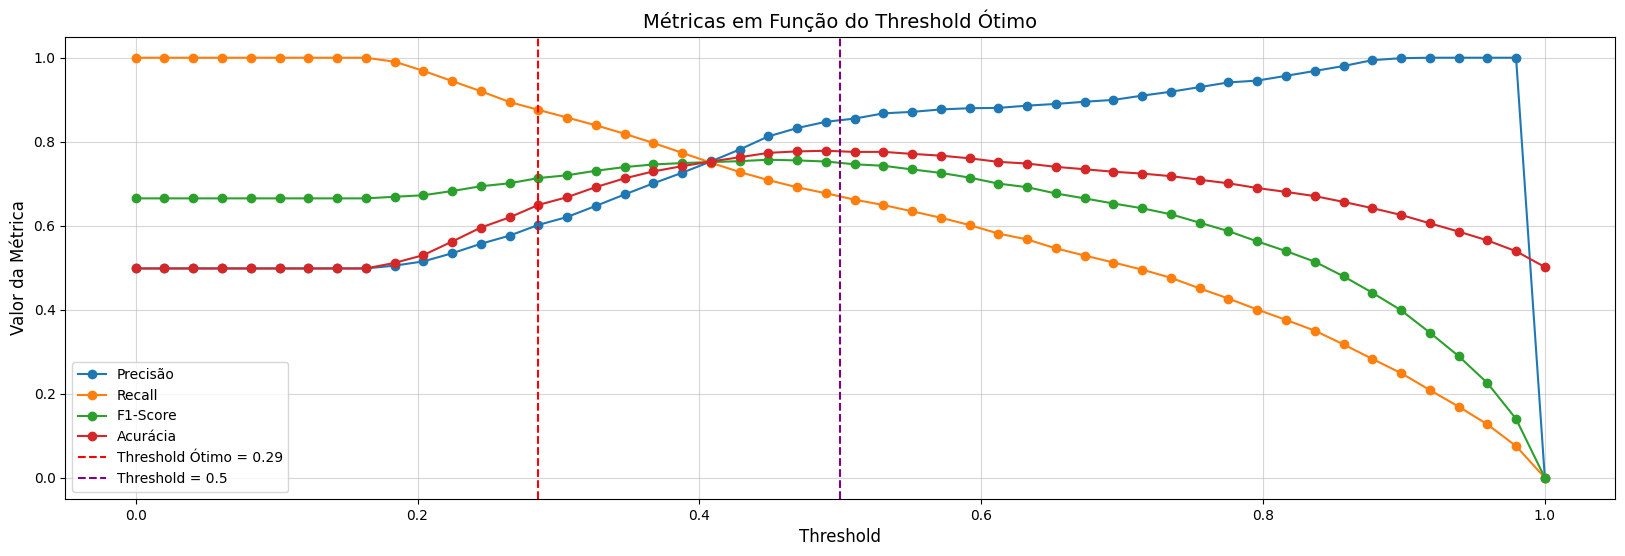

Gráfico de sensibilidade/especificidade salvo


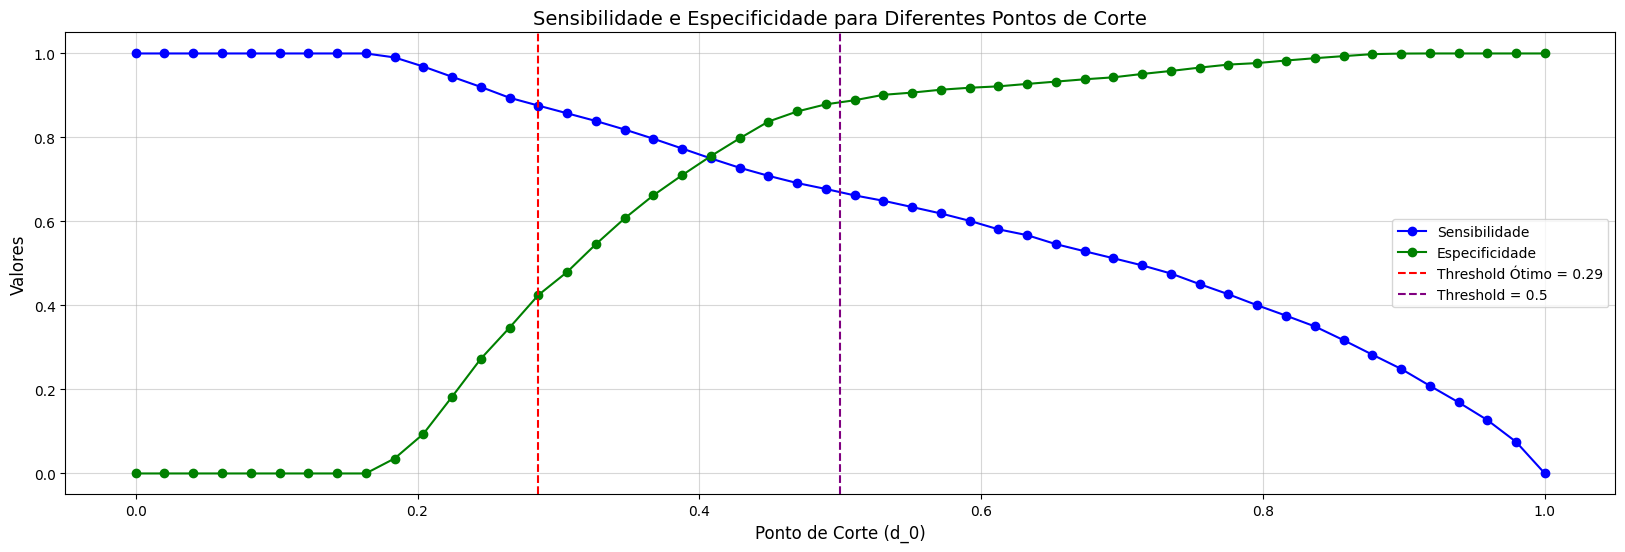


Threshold Ótimo (Precision >= 60.0%): 0.2857
Melhor Recall com Threshold Ótimo: 0.8759


In [17]:
optimal_threshold, y_pred_th_otimo, y_prob_th, thresholds = ajustar_threshold(model_lr, X_train, X_test, y_train, y_test, threshold_precision=0.6, metric='recall', model_name='Métricas em função de Threshold LogisticRegression')

In [18]:
optimal_threshold_lr = optimal_threshold
y_pred_th_otimo_lr = y_pred_th_otimo
y_prob_th_lr = y_prob_th

Salvando objetos em .pkl - variáveis precessadas

In [19]:
# Obter o caminho absoluto do diretório do projeto
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))

# Caminho completo para a pasta src/data/processed_data
src_path = os.path.join(project_path, 'src/data/processed_data')
os.makedirs(src_path, exist_ok=True)

# Salvar arquivos diretamente na pasta correta
joblib.dump(y_pred_lr, os.path.join(src_path, 'y_pred_lr.pkl'))
joblib.dump(y_pred_th_otimo_lr, os.path.join(src_path, 'y_pred_th_otimo_lr.pkl'))
joblib.dump(y_prob_th_lr, os.path.join(src_path, 'y_prob_th_lr.pkl'))
joblib.dump(thresholds, os.path.join(src_path, 'thresholds.pkl'))



print("Dados salvos com sucesso!")

Dados salvos com sucesso!


Salvando objetos em .pkl - modelo treinado

In [20]:
# Obter o caminho absoluto do diretório do projeto
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))

# Caminho completo para a pasta src/models/train_saved
src_path = os.path.join(project_path, 'src/models/train_saved')
os.makedirs(src_path, exist_ok=True)

# Salvar arquivos diretamente na pasta correta
joblib.dump(model_lr, os.path.join(src_path, 'model_lr.pkl'))
joblib.dump(optimal_threshold_lr, os.path.join(src_path, 'optimal_threshold_lr.pkl'))



print("Dados salvos com sucesso!")

Dados salvos com sucesso!
